# AUDIOMATE Processing

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import IPython

import audiomate
from audiomate.corpus import assets
from audiomate.processing import pipeline

/Users/matthi/Repos/pingu/.venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First the dataset is loaded. It is in the format of the UrbanSound8k dataset, but just 3 files of it.

In [2]:
urbansound8k_subset = audiomate.Corpus.load('data/urbansound_subset', reader='urbansound8k')

## Extracting Mel-Spectrogram Features with deltas

In [3]:
feature_path = 'output/mel_features.h5py'
feature_online_path = 'output/mel_features_online.h5py'

frame_size = 1024
hop_size = 512
sampling_rate = 16000

In order to compute the features with deltas multiple steps have to be executed. These steps are arranged in a pipeline using the `parent` and `parents` attributes of the different steps. The steps itself mostly just wrap corresponding functions of the `librosa` library.

In [4]:
mel_extractor = pipeline.MelSpectrogram(n_mels=60)
power_to_db = pipeline.PowerToDb(ref=np.max, parent=mel_extractor)
deltas = pipeline.Delta(parent=power_to_db)
stack = pipeline.Stack(parents=[power_to_db, deltas])

Now we have defined the pipeline. Now we can execute some processing function on the last step to execute the full pipeline. The default methods are running in offline mode. This means all frames of an utterance are processed at once.

In [5]:
feat_container = stack.process_corpus(urbansound8k_subset, 
                                      feature_path, 
                                      frame_size=frame_size, 
                                      hop_size=hop_size, 
                                      sr=sampling_rate)

/Users/matthi/Repos/pingu/.venv/lib/python3.6/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)


To process the frames in streaming mode, we have to use the corresponding `_online` method. Now we can define via ``chunk_size`` how much frames at a time are processed. Depending on the pipeline steps we can define if context has to be added for processing. For example when computing deltas some context is required. There is no automatic check implemented if a step is only working in online or offline mode. It is up to the user to apply it correctly. 

In [6]:
feat_container = stack.process_corpus_online(urbansound8k_subset, 
                                             feature_online_path, 
                                             frame_size=frame_size, 
                                             hop_size=hop_size, 
                                             sr=sampling_rate,
                                             chunk_size=50,
                                             chunk_left_context=10,
                                             chunk_right_context=10)

### Reading features
The features are written to a HDF5 file. These can be read using the `FeatureContainer` class.

18581-3-1-1 (dog_bark) (4.0 s)
----------------------------------------------------------------------------------------------------


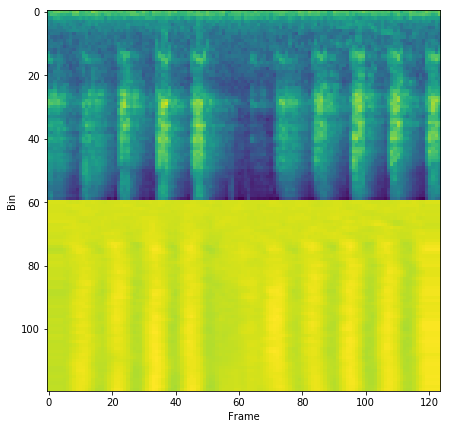

204773-3-8-0 (dog_bark) (4.0 s)
----------------------------------------------------------------------------------------------------


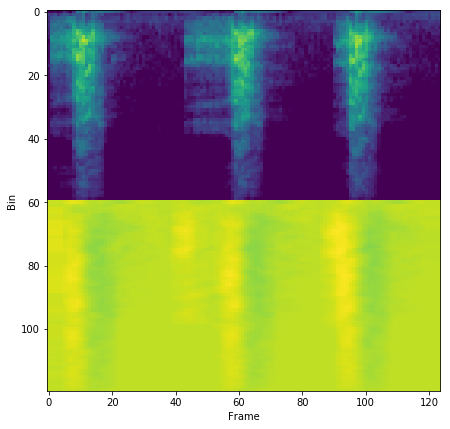

14772-7-2-0 (jackhammer) (1.1489795918367347 s)
----------------------------------------------------------------------------------------------------


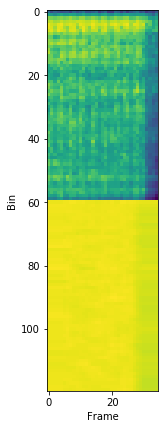

In [7]:
feat_container = assets.FeatureContainer(feature_path)

with feat_container:
    for utterance in urbansound8k_subset.utterances.values():        
        samples_of_utterance = utterance.read_samples(sr=sampling_rate)
        features_of_utterance = feat_container.get(utterance.idx, mem_map=False)
                
        print('{} ({}) ({} s)'.format(utterance.idx, 
                                    utterance.label_lists['default'][0].value,
                                    utterance.duration))
        print('-'*100)
        
        # Display audio player
        IPython.display.display(IPython.display.Audio(samples_of_utterance, rate=sampling_rate) )
        
        # Display Features
        fig, ax  = plt.subplots(figsize=(30,7))
        im = plt.imshow(features_of_utterance.T)
        ax.set_xlabel('Frame')
        ax.set_ylabel('Bin')
        plt.show()
        